In [25]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd

In [26]:
pwd

'/mnt/c/Users/sinad/Dropbox (Gladstone)/Feature_based_classification'

In [27]:
in_path = {'class1':'/mnt/c/Users/sinad/Dropbox (Gladstone)/Feature_based_classification/FIJI_SingleTp_S_CTR_1',
           'class2':'/mnt/c/Users/sinad/Dropbox (Gladstone)/Feature_based_classification/FIJI_SingleTp_N_CTR_1'}
class_list = ['class1', 'class2']

img_list_class1 = os.listdir(in_path['class1'])
img_list_class2 = os.listdir(in_path['class2'])

(300, 300)

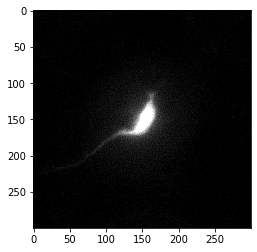

In [28]:
current_img_path = os.path.join(in_path['class1'], img_list_class1[6])
current_img = cv2.imread(current_img_path)
plt.imshow(current_img)
row, col,_ = current_img.shape
row, col

In [29]:
def csv_file_updater(input_path, cl, img_mean_list):
    csv_file_path = '\\'.join(str(input_path).split('\\')[0:-1])
    print("the csv file path: ", input_path)
    csv_file = os.path.join(csv_file_path, 'classifier_output.csv')
    # print("the img_mean_list is: ", img_mean_list)

    img_mean_list_file_names = os.listdir(input_path)
    #     print("img_mean_list_file_names is: ", img_mean_list_file_names)
    print("the img_mean_list: ", img_mean_list)
    img_mean_list_values = [fn for fn in img_mean_list]
    #     print("img_mean_list_values is: ", img_mean_list_values)
    df = pd.DataFrame(data={"Class": cl, "Folder": input_path, "FileNames":
        img_mean_list_file_names, "Mean circle pix intensity":
                                img_mean_list_values})
    return df, csv_file

In [30]:
def eccentricity(input_path, img_list_class):
    
    img_eccentricity_list = []
    for img in img_list_class:
        current_img_path = os.path.join(input_path, img)
        current_img = cv2.imread(current_img_path)
        current_img_normalized = (current_img - current_img.min()) / (current_img.max() - current_img.min())
    #     plt.hist(current_img_normalized.ravel(), bins=256)
        current_img_normalized_mean = current_img_normalized.mean()
        current_img_normalized_std = current_img_normalized.std()
        mean_correction_factor = 0.25 - current_img_normalized_mean
        stdDev_correction_factor = 0.125 / current_img_normalized_std
        current_img_standardized = (current_img_normalized - mean_correction_factor) * stdDev_correction_factor
        current_img_standardized_corrected = current_img_standardized + (0.25 - current_img_standardized.mean())
        current_img_standardized_clipped = current_img_standardized_corrected.clip(0.02, 0.9)
        current_img_standardized_clipped_rescaled = np.array(current_img_standardized_clipped * pow(2,8), dtype=np.uint8)
        imgray = cv2.cvtColor(current_img_standardized_clipped_rescaled, cv2.COLOR_BGR2GRAY)

        ret, thresh = cv2.threshold(imgray, 150, 255, 0)
#         plt.imshow(current_img_standardized_clipped_rescaled)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour_length = []
        for c in contours:
            contour_length.append(len(c))

    #     print("the length of contours are: ", contour_length)
        contour_max_idx = contour_length.index(max(contour_length))
#         print("the index of the max contour is: ", contour_max_idx)
        cnt = contours[contour_max_idx]
    #     print("the contours points are: ", contours)
        threshold_ellipse = cv2.fitEllipse(cnt)
        (center, axis, orientation) = threshold_ellipse
        major_axis = max(axis)
        minor_axis = min(axis)
        # print("the major and minor axis are: ", major_axis, minor_axis)
        eccentricity = np.sqrt(1-(minor_axis/major_axis)**2)
        current_img_eccentricity = np.round(eccentricity, 2)
        img_eccentricity_list.append(current_img_eccentricity)
    return img_eccentricity_list

In [31]:
def mean_circle_pix_intensity(input_path, img_list_class):
    img_mean_list = []
    blank_img = np.zeros((row, col, 3), dtype=np.uint8)
    circle_mask = cv2.circle(blank_img, (150,150), 25, (1,1,1), -1)
    
    for img in img_list_class:
        current_img_path = os.path.join(input_path, img)
        current_img = cv2.imread(current_img_path)
        current_img_filtered = current_img*circle_mask
        current_img_filtered_mean = np.round(np.mean(current_img_filtered), 2)
#         if current_img_filtered_mean > 1.04:
        img_mean_list.append(current_img_filtered_mean)
    return img_mean_list

In [59]:
def fft_hpf_differences(input_path, img_list_class):

    img_fft_hpf_list = []
    for img in img_list_class:
        current_img_path = os.path.join(input_path, img)
        current_img = cv2.imread(current_img_path, 0)
        row, col = current_img.shape
        centerRow, centerCol = int(row/2), int(col/2)
        centerRectangle = 7
        dft = cv2.dft(np.float32(current_img), flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)
        # High pass filtering: blocking a square in the middle
        dft_shift[centerRow - centerRectangle: centerRow + centerRectangle,
                     centerCol - centerRectangle: centerCol + centerRectangle] = 0
        # Going back: inverse fft
        dft_ifft = np.fft.ifftshift(dft_shift)
        img_back = cv2.idft(dft_ifft)
        img_back = 20*np.log(cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1]))
        median_img_back = np.median(img_back.ravel())
        img_fft_hpf_list.append([img, median_img_back])

    # print('The images and their median pix after fft hpf are: ', img_fft_hpf_list, '\n')
    img_fft_hpf_list_class_values = [i[1] for i in img_fft_hpf_list]

    return img_fft_hpf_list_class_values


In [32]:

img_list_class_values = {}

csv_file_path = '\\'.join(str(in_path).split('\\')[0:-1])
print("the csv file path: ", in_path)
csv_file = os.path.join(csv_file_path, 'classifier_output.csv')
file = open(csv_file, "r+")
file.truncate(0)
file.close()

for cl in class_list:
    assert os.path.exists(in_path[cl]), "Please confirm the input path is correct."
    img_list_class = os.listdir(in_path[cl])
#     print(img_list)
#     class_label = [(cl+', ') * len(img_list_class)]
#     img_list_class_values[cl] = [img_list_class, mean_circle_pix_intensity(in_path[cl], img_list_class),
#                                 eccentricity(in_path[cl], img_list_class)]
    img_list_class_values[cl] = mean_circle_pix_intensity(in_path[cl], img_list_class)
        
    print(np.shape(img_list_class), np.shape(mean_circle_pix_intensity(in_path[cl], img_list_class)), 
          np.shape(eccentricity(in_path[cl], img_list_class)))
    df, csv_file = csv_file_updater(in_path[cl], cl, img_list_class_values[cl])
    if cl == 'class1':
        df.to_csv(csv_file, sep=',', index=False, mode='a', header=True)
    else:
        df.to_csv(csv_file, sep=',', index=False, mode='a', header=False)
    
# img_list_class_values

the csv file path:  {'class1': '/mnt/c/Users/sinad/Dropbox (Gladstone)/Feature_based_classification/FIJI_SingleTp_S_CTR_1', 'class2': '/mnt/c/Users/sinad/Dropbox (Gladstone)/Feature_based_classification/FIJI_SingleTp_N_CTR_1'}
(105,) (105,) (105,)
the csv file path:  /mnt/c/Users/sinad/Dropbox (Gladstone)/Feature_based_classification/FIJI_SingleTp_S_CTR_1
the img_mean_list:  [3.8, 3.33, 3.8, 3.68, 3.66, 3.18, 3.0, 3.83, 3.25, 3.32, 3.94, 2.77, 3.1, 3.53, 3.44, 3.02, 3.34, 3.11, 2.64, 3.38, 3.02, 2.56, 3.02, 3.02, 3.37, 3.33, 3.91, 3.14, 2.69, 3.3, 2.89, 0.64, 2.9, 2.97, 2.05, 2.8, 2.89, 3.32, 2.07, 3.02, 3.32, 3.24, 2.97, 3.36, 2.99, 2.44, 2.7, 2.99, 2.93, 3.59, 2.87, 3.44, 3.7, 3.02, 3.69, 3.44, 3.5, 3.12, 3.15, 3.45, 2.8, 0.26, 0.83, 2.96, 2.71, 2.78, 2.77, 2.97, 2.84, 0.26, 3.31, 2.58, 2.49, 3.79, 3.15, 2.74, 2.87, 3.28, 1.93, 1.36, 2.0, 2.99, 1.29, 2.49, 2.82, 2.47, 3.36, 2.38, 2.85, 2.72, 3.83, 2.98, 3.81, 2.31, 2.46, 2.98, 3.63, 2.72, 2.25, 3.0, 3.32, 1.87, 0.22, 1.86, 2.95]
(134

In [33]:
print(img_list_class_values[class_list[0]][0])
os.listdir(in_path[class_list[0]])

3.8


['PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_9.tif',
 'PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif',
 'PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif',
 'PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif',
 'PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif',
 'PID20190102_SB11-15-Plate1_T0_0_D9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_13.tif',
 'PID20190102_SB11-15-Plate1_T0_0_D9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_8.tif',
 'PID20190102_SB11-15-Plate1_T0_0_E10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif',
 'PID20190102_SB11-15-Plate1_T0_0_E8_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif',
 'PID20190102_SB11-15-Plate1_T0_0_G10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif',
 'PID20190102_SB11-15-Plate2_T0_0_A8_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_10.tif',
 'PID20190102_SB11-15-Plate2_T0_0_A9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_10.tif',
 'PID20190102_SB11-15-Plate2_T0_0_C10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif',
 

In [34]:


cl = class_list[0]
data_index = os.listdir(in_path[cl])
img_mean_list_values = mean_circle_pix_intensity(in_path[cl], data_index)
# print(img_mean_list_values)
df = pd.DataFrame(data={"FileNames": data_index, 
                        "Mean circle pix intensity": img_mean_list_values})
df
# img_list_class_values[class_list[1]]
# img_list_class_values[class_list[1]][0]
#  'Eccentricity',
# , columns=column_names

,FileNames,Mean circle pix intensity
0,PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTr...,3.80
1,PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTr...,3.33
2,PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTr...,3.80
3,PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrC...,3.68
4,PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrC...,3.66
...,...,...
100,PID20190727_EV21-25-Plate2_T0_0_D11_0_RFP-DFTr...,3.32
101,PID20190727_EV21-25-Plate2_T0_0_D3_0_RFP-DFTrC...,1.87
102,PID20190727_EV21-25-Plate2_T0_0_D3_0_RFP-DFTrC...,0.22
103,PID20190727_EV21-25-Plate2_T0_0_D3_0_RFP-DFTrC...,1.86


In [35]:
cl2 = class_list[1]
print(cl2)
data_index2 = os.listdir(in_path[cl2])
img_mean_list_values2 = img_list_class_values[cl2]
# print(img_mean_list_values)
df2 = pd.DataFrame(data={"FileNames": data_index2[0:105], 
                        "Mean circle pix intensity": img_mean_list_values2[0:105]})
df2

class2


,FileNames,Mean circle pix intensity
0,PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTr...,1.37
1,PID20190102_SB11-15-Plate1_T0_0_A12_0_RFP-DFTr...,1.60
2,PID20190102_SB11-15-Plate1_T0_0_A6_0_RFP-DFTrC...,1.91
3,PID20190102_SB11-15-Plate1_T0_0_A6_0_RFP-DFTrC...,0.07
4,PID20190102_SB11-15-Plate1_T0_0_A7_0_RFP-DFTrC...,1.20
...,...,...
100,PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFT...,1.69
101,PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFT...,1.20
102,PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFT...,2.17
103,PID20190606_EV11-15-automated_T0_0_G2_0_RFP-DF...,0.38


In [36]:
df_complete = df.append(df2)
df_complete

,FileNames,Mean circle pix intensity
0,PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTr...,3.80
1,PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTr...,3.33
2,PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTr...,3.80
3,PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrC...,3.68
4,PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrC...,3.66
...,...,...
100,PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFT...,1.69
101,PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFT...,1.20
102,PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFT...,2.17
103,PID20190606_EV11-15-automated_T0_0_G2_0_RFP-DF...,0.38


In [37]:
df_complete.set_index("FileNames",inplace=True)

In [38]:
df_complete

,Mean circle pix intensity
FileNames,
PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_9.tif,3.80
PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,3.33
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif,3.80
PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif,3.68
PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,3.66
...,...
PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_18.tif,1.69
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,1.20
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_5.tif,2.17


In [39]:
df_complete['Mean circle pix intensity'].mean()

2.1785714285714284

In [40]:
df_complete_normalized = (df_complete - df_complete.min()) \
/ (df_complete.max() - df_complete.min())
df_complete_normalized

,Mean circle pix intensity
FileNames,
PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_9.tif,0.944724
PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.826633
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif,0.944724
PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif,0.914573
PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.909548
...,...
PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_18.tif,0.414573
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.291457
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_5.tif,0.535176


In [41]:
cl = class_list[0]
data_index = os.listdir(in_path[cl])
img_ecc_list_values = eccentricity(in_path[cl], data_index)
# print(img_mean_list_values)
df_ecc = pd.DataFrame(data={"FileNames": data_index, 
                        "Eccentricity": img_ecc_list_values})
cl2 = class_list[1]
print(cl2)
data_index2 = os.listdir(in_path[cl2])
img_ecc_list_values2 = eccentricity(in_path[cl2], data_index2[0:105])
# print(img_mean_list_values)
df2_ecc = pd.DataFrame(data={"FileNames": data_index2[0:105], 
                        "Eccentricity": img_ecc_list_values2[0:105]})

df_ecc_complete = df_ecc.append(df2_ecc)
df_ecc_complete.set_index("FileNames",inplace=True)
df_ecc_complete

class2


,Eccentricity
FileNames,
PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_9.tif,0.66
PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.72
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif,0.54
PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif,0.60
PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.71
...,...
PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_18.tif,0.89
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,1.00
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_5.tif,0.90


In [42]:
df_ecc_complete_combo = df_complete_normalized.merge(df_ecc_complete,on=['FileNames'])
df_ecc_complete_combo

,Mean circle pix intensity,Eccentricity
FileNames,,
PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_9.tif,0.944724,0.66
PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.826633,0.72
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif,0.944724,0.54
PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif,0.914573,0.60
PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.909548,0.71
...,...,...
PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_18.tif,0.414573,0.89
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.291457,1.00
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_5.tif,0.535176,0.90


In [65]:
cl = class_list[0]
data_index = os.listdir(in_path[cl])
print(np.shape(data_index))
img_hpf_list_values = fft_hpf_differences(in_path[cl], data_index)
# print(img_hpf_list_values)
df_hpf = pd.DataFrame(data={"FileNames": data_index, 
                        "FFT HPF": img_hpf_list_values})
cl2 = class_list[1]

data_index2 = os.listdir(in_path[cl2])
print(np.shape(data_index2))
img_hpf_list_values2 = fft_hpf_differences(in_path[cl2], data_index2[0:105])
# print(img_mean_list_values)
df2_hpf = pd.DataFrame(data={"FileNames": data_index2[0:105], 
                        "FFT HPF": img_hpf_list_values2[0:105]})

df_hpf_complete = df_hpf.append(df2_hpf)
df_hpf_complete.set_index("FileNames",inplace=True)
df_hpf_complete

(105,)
(134,)


,FFT HPF
FileNames,
PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_9.tif,231.304047
PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,231.974945
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif,251.544373
PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif,242.357635
PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,239.685669
...,...
PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_18.tif,288.968079
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,270.912354
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_5.tif,278.435516


In [67]:
df_hpf_complete_normalized = (df_hpf_complete - df_hpf_complete.min()) \
/ (df_hpf_complete.max() - df_hpf_complete.min())
df_hpf_complete_normalized

,FFT HPF
FileNames,
PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_9.tif,0.245062
PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.252259
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif,0.462179
PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif,0.363634
PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.334972
...,...
PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_18.tif,0.863622
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.669939
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_5.tif,0.750639


In [87]:
df_hpf_complete_combo = df_ecc_complete_combo.merge(df_hpf_complete_normalized,on=['FileNames'])
df_hpf_complete_combo = np.round(df_hpf_complete_combo, 2)
df_hpf_complete_combo

,Mean circle pix intensity,Eccentricity,FFT HPF
FileNames,,,
PID20190102_SB11-15-Plate1_T0_0_A10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_9.tif,0.94,0.66,0.25
PID20190102_SB11-15-Plate1_T0_0_B10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.83,0.72,0.25
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_11.tif,0.94,0.54,0.46
PID20190102_SB11-15-Plate1_T0_0_C6_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif,0.91,0.60,0.36
PID20190102_SB11-15-Plate1_T0_0_D7_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.91,0.71,0.33
...,...,...,...
PID20190520_EV6-10-automated_T0_0_F3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_18.tif,0.41,0.89,0.86
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.29,1.00,0.67
PID20190520_EV6-10-automated_T0_0_F9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_5.tif,0.54,0.90,0.75


In [69]:
class1_labels = np.zeros(105)
print(class1_labels.shape)
class2_labels = np.ones(105)
print(class2_labels.shape)

(105,)
(105,)


In [70]:
img_label_list_combined = np.append(class1_labels, class2_labels)
img_label_list_combined_reshaped = img_label_list_combined.reshape(-1, 1)
print(img_label_list_combined_reshaped)


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [88]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_hpf_complete_combo, 
                                                    img_label_list_combined_reshaped, test_size=0.14, 
                                                    random_state=0)

In [89]:
print(x_train.shape)
print(x_test.shape)

(180, 3)
(30, 3)


In [90]:
# Make an instance of the model
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()

In [91]:
# Training
clf = logisticRegr.fit(x_train, y_train.ravel())
# coef_ corresponds to the weights of each feature
print("The coef_ for circle, ecc. and fft-hpf features are: ", np.round(clf.coef_, 2))
std_circle = np.std(x_train['Mean circle pix intensity'], 0)
std_ecc = np.std(x_train['Eccentricity'], 0)
std_hpf = np.std(x_train['FFT HPF'], 0)
print("The standard deviation of circle feature, eccen., and fft-hpf are: ", 
      np.round(std_circle,2), np.round(std_ecc,2), np.round(std_hpf, 2))
weighted_circle = std_circle*clf.coef_[0][0]
weighted_ecc = std_ecc*clf.coef_[0][1]
weighted_hpf = std_hpf*clf.coef_[0][2]
print("The normalized coef are: ", [np.round(weighted_circle,2), np.round(weighted_ecc,2), 
                                   np.round(weighted_hpf,2)])

The coef_ for circle, ecc. and fft-hpf features are:  [[-3.63  2.79  2.86]]
The standard deviation of circle feature, eccen., and fft-hpf are:  0.26 0.18 0.18
The normalized coef are:  [-0.93, 0.51, 0.52]


In [92]:
test_predictions = logisticRegr.predict(x_test)
print("The predictions on test images are: ", test_predictions)
x_test

The predictions on test images are:  [0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 1.]


,Mean circle pix intensity,Eccentricity,FFT HPF
FileNames,,,
PID20190102_SB11-15-Plate2_T0_0_C10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.77,0.79,0.30
PID20190606_EV11-15-automated_T0_0_G6_0_RFP-DFTrCy5_BGpbs_MN_26.tif,0.49,0.29,0.64
PID20190131_SB21-25-plate6_T1_24_A3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_7.tif,0.74,0.77,0.34
PID20190102_SB11-15-Plate1_T0_0_D9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_13.tif,0.79,0.84,0.39
PID20190206_SB26-30plate2_T1_24_G4_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.35,0.91,0.54
PID20190606_EV11-15-automated_T0_0_G9_0_RFP-DFTrCy5_BGpbs_MN_3.tif,0.62,0.51,0.49
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.02,0.56,0.57
PID20190102_SB11-15-Plate2_T0_0_A8_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_7.tif,0.39,1.00,0.57
PID20190727_EV21-25-Plate1_T0_0_B4_0_RFP-DFTrCy5_BGpbs_MN_1.tif,0.95,0.42,0.46


In [93]:
y_test_series = pd.DataFrame(y_test, columns=['label'])
y_test_series.set_index(x_test.index, inplace=True)
y_test_series
# x_test.append(y_test_series)

,label
FileNames,
PID20190102_SB11-15-Plate2_T0_0_C10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.0
PID20190606_EV11-15-automated_T0_0_G6_0_RFP-DFTrCy5_BGpbs_MN_26.tif,0.0
PID20190131_SB21-25-plate6_T1_24_A3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_7.tif,0.0
PID20190102_SB11-15-Plate1_T0_0_D9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_13.tif,0.0
PID20190206_SB26-30plate2_T1_24_G4_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,1.0
PID20190606_EV11-15-automated_T0_0_G9_0_RFP-DFTrCy5_BGpbs_MN_3.tif,0.0
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,1.0
PID20190102_SB11-15-Plate2_T0_0_A8_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_7.tif,1.0
PID20190727_EV21-25-Plate1_T0_0_B4_0_RFP-DFTrCy5_BGpbs_MN_1.tif,0.0


In [94]:
x_test_merged = x_test.merge(y_test_series, on=['FileNames'])
x_test_merged

,Mean circle pix intensity,Eccentricity,FFT HPF,label
FileNames,,,,
PID20190102_SB11-15-Plate2_T0_0_C10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.77,0.79,0.30,0.0
PID20190606_EV11-15-automated_T0_0_G6_0_RFP-DFTrCy5_BGpbs_MN_26.tif,0.49,0.29,0.64,0.0
PID20190131_SB21-25-plate6_T1_24_A3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_7.tif,0.74,0.77,0.34,0.0
PID20190102_SB11-15-Plate1_T0_0_D9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_13.tif,0.79,0.84,0.39,0.0
PID20190206_SB26-30plate2_T1_24_G4_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.35,0.91,0.54,1.0
PID20190606_EV11-15-automated_T0_0_G9_0_RFP-DFTrCy5_BGpbs_MN_3.tif,0.62,0.51,0.49,0.0
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.02,0.56,0.57,1.0
PID20190102_SB11-15-Plate2_T0_0_A8_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_7.tif,0.39,1.00,0.57,1.0
PID20190727_EV21-25-Plate1_T0_0_B4_0_RFP-DFTrCy5_BGpbs_MN_1.tif,0.95,0.42,0.46,0.0


In [95]:
test_predictions_series = pd.DataFrame(test_predictions, columns=['predictions'])
np.shape(test_predictions_series)
test_predictions_series.set_index(x_test.index, inplace=True)
test_predictions_series
x_test_merged_predictions = x_test_merged.merge(test_predictions_series, on=['FileNames'])
x_test_merged_predictions

,Mean circle pix intensity,Eccentricity,FFT HPF,label,predictions
FileNames,,,,,
PID20190102_SB11-15-Plate2_T0_0_C10_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.77,0.79,0.30,0.0,0.0
PID20190606_EV11-15-automated_T0_0_G6_0_RFP-DFTrCy5_BGpbs_MN_26.tif,0.49,0.29,0.64,0.0,0.0
PID20190131_SB21-25-plate6_T1_24_A3_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_7.tif,0.74,0.77,0.34,0.0,0.0
PID20190102_SB11-15-Plate1_T0_0_D9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_13.tif,0.79,0.84,0.39,0.0,0.0
PID20190206_SB26-30plate2_T1_24_G4_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_2.tif,0.35,0.91,0.54,1.0,1.0
PID20190606_EV11-15-automated_T0_0_G9_0_RFP-DFTrCy5_BGpbs_MN_3.tif,0.62,0.51,0.49,0.0,0.0
PID20190102_SB11-15-Plate1_T0_0_B11_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_4.tif,0.02,0.56,0.57,1.0,1.0
PID20190102_SB11-15-Plate2_T0_0_A8_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_7.tif,0.39,1.00,0.57,1.0,1.0
PID20190727_EV21-25-Plate1_T0_0_B4_0_RFP-DFTrCy5_BGpbs_MN_1.tif,0.95,0.42,0.46,0.0,0.0


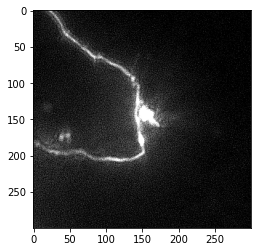

In [96]:
img_location = os.path.join(in_path['class2'],
                            'PID20190102_SB11-15-Plate2_T0_0_B9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif')
plt.imshow(cv2.imread(img_location))

In [97]:
predictions = logisticRegr.predict(x_train)
predictions_test = logisticRegr.predict(x_test)
print(predictions)

[0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.]


In [103]:
# using accuracy as a measure of performance
score = logisticRegr.score(x_test, y_test.reshape(-1,1))
print("test score is: ", score)
score_train = logisticRegr.score(x_train, y_train.reshape(-1, 1))
score_train = np.round(score_train, 2)
print("train score is: ", score_train)

test score is:  0.9666666666666667
train score is:  0.91


In [105]:
# Confusion Matrix
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_train.reshape(-1,1), predictions)

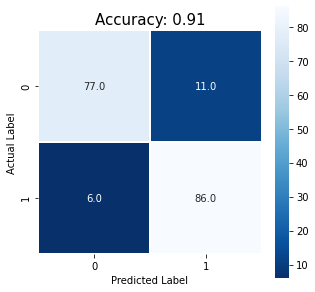

In [106]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');
all_sample_title = 'Accuracy: {0}'.format(np.round(score_train,2))
plt.title(all_sample_title, size=15);
plt.savefig('feature_confusion_matrix.png')

In [108]:
x_test.iloc[27]

Mean circle pix intensity    0.82
Eccentricity                 0.74
FFT HPF                      0.72
Name: PID20190102_SB11-15-Plate2_T0_0_B9_0_RFP-DFTrCy5_BGpbs_MN_ALIGNED_6.tif, dtype: float64